<a href="https://colab.research.google.com/github/alisonmitchell/Biomedical-Knowledge-Graph/blob/main/05_Relation_Extraction/LangChain_LLMs_KGs.ipynb"
   target="_parent">
   <img src="https://colab.research.google.com/assets/colab-badge.svg"
      alt="Open in Colab">
</a>

# LangChain, LLMs and Knowledge Graphs

## 1. Introduction

LLMs have revolutionised NLP and AI due to their general knowledge, generalisability, and capabilities in language processing and generating human-like responses. However, they have a knowledge cutoff date, and their training data does not include external domain-specific data sources. This lack of real-time and real-world factual information often results in hallucinations.

In contrast, Knowledge Graphs (KGs) are structured knowledge models that explicitly store rich factual knowledge, but lack language understanding.

[Shirui Pan et al. (2024)](https://arxiv.org/pdf/2306.08302) propose a roadmap for the unification of LLMs and KGs consisting of three general frameworks: KG-enhanced LLMs, LLM-augmented KGs, and Synergised LLMs + KGs.

![Summarisation of the pros and cons for LLMs and KGs.](images/2306.08302_Unifying_Large_Language_Models_and_Knowledge_Graphs_A_Roadmap_S_Pan_2024.png)

We will follow [Maxime Labonne's tutorial](https://mlabonne.github.io/blog/posts/Article_Improve_ChatGPT_with_Knowledge_Graphs.html)  and explore LLMs for knowledge graph construction, and the leveraging of knowledge graphs for LLMs using [LangChain](https://github.com/langchain-ai), an open-source orchestration framework for developing context-aware, reasoning applications powered by language models. This integration of the structured clarity of knowledge graphs into unstructured LLMs grounds the model and ensures accurate, relevant, up-to-date responses from RAG applications.


## 2. Install/import libraries

In [ ]:
!pip install openai tiktoken langchain

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import openai
import tiktoken
import networkx as nx

from langchain.llms import OpenAI
from langchain.indexes import GraphIndexCreator
from langchain.chains import GraphQAChain
from langchain.prompts import PromptTemplate
from langchain.graphs.networkx_graph import KnowledgeTriple

In [ ]:
with open("api_keys.json") as f:
    data = json.load(f)

In [ ]:
# Load OpenAI API key
openai.api_key = data['keys']["OPENAI_API_KEY"]

## 3. Querying ChatGPT on training data

We will define a function to generate text using the chat completions endpoint in the OpenAI REST API.

Here the `openai.ChatCompletion.create()` method is used to generate chat completions, however this endpoint is no longer supported so would need to be replaced with `client.chat.completions.create()`. Refer to the [OpenAI Platform](https://platform.openai.com/docs/api-reference/chat) for the current endpoints.

In [ ]:
def answer_question_chatgpt(question):
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        temperature=0,
        messages=[{"role": "user",
                   "content": question}])
    api_usage = response['usage']
    print(
        f"Completion tokens: {api_usage['completion_tokens']}",
        f"Prompt tokens: {api_usage['prompt_tokens']}",
        f"Total tokens: {api_usage['total_tokens']}", sep='\n')
    print('')
    return response.choices[0].message.content

We will test the function by asking a few questions relating to treatments for COVID-19 for which data was available before gpt-3.5-turbo's knowledge cutoff date of September 2021.

In [ ]:
chatgpt_result = answer_question_chatgpt(question="Is Nirmatrelvir/ritonavir used to treat coronavirus?")
chatgpt_result

Completion tokens: 122
Prompt tokens: 23
Total tokens: 145



'Nirmatrelvir/ritonavir is a combination antiviral medication that has been authorized for emergency use by the U.S. Food and Drug Administration (FDA) to treat mild to moderate cases of COVID-19 in certain high-risk individuals. It is specifically indicated for use in adults and pediatric patients (12 years of age and older weighing at least 40 kg) who are at high risk for progressing to severe COVID-19, including hospitalization or death. However, it is important to note that the use of this medication should be based on the specific recommendations and guidance of healthcare professionals.'

In [ ]:
chatgpt_result = answer_question_chatgpt(question="What is recommended if Nirmatrelvir/ritonavir is not suitable?")
chatgpt_result

Completion tokens: 71
Prompt tokens: 25
Total tokens: 96



"If Nirmatrelvir/ritonavir is not suitable, there are alternative treatment options available for various conditions. The specific recommendation would depend on the condition being treated. It is important to consult with a healthcare professional who can evaluate the individual's medical history, current condition, and any contraindications to determine the most appropriate alternative treatment."

In [ ]:
chatgpt_result = answer_question_chatgpt(question="What is recommended for treating coronavirus if Nirmatrelvir/ritonavir is not suitable?")
chatgpt_result

Completion tokens: 261
Prompt tokens: 28
Total tokens: 289



'If Nirmatrelvir/ritonavir is not suitable for treating coronavirus, there are several other treatment options available. These include:\n\n1. Monoclonal Antibodies: Monoclonal antibody therapies like casirivimab/imdevimab and sotrovimab have been authorized for emergency use in certain cases. These antibodies can help reduce the severity of symptoms and prevent hospitalization in high-risk individuals.\n\n2. Antiviral Medications: Antiviral drugs like remdesivir have been used to treat COVID-19 patients, particularly those with severe illness requiring hospitalization. Remdesivir works by inhibiting the replication of the virus.\n\n3. Corticosteroids: In severe cases, corticosteroids like dexamethasone have shown to be effective in reducing mortality rates. These medications help suppress the immune response and inflammation caused by the virus.\n\n4. Oxygen Therapy: For patients with severe respiratory distress, supplemental oxygen therapy may be necessary. This can be provided throu

In [ ]:
chatgpt_result = answer_question_chatgpt(question="Did the World Health Organization recommend baricitinib for treating COVID-19?")
chatgpt_result

Completion tokens: 102
Prompt tokens: 23
Total tokens: 125



'Yes, the World Health Organization (WHO) has recommended the use of baricitinib in combination with remdesivir for the treatment of COVID-19 in certain hospitalized patients. This recommendation was made based on evidence from clinical trials showing that the combination therapy can reduce the time to recovery and improve outcomes in hospitalized patients requiring supplemental oxygen or high-flow oxygen or non-invasive ventilation. However, it is important to note that this recommendation is specific to certain patient populations and should be used under appropriate medical supervision.'

## 4.  Querying ChatGPT on real-time data

We will try querying ChatGPT on data which was not available before September 2021.

According to a [press release by Shionogi](https://www.shionogi.com/global/en/news/2023/04/20230404.html) on April 4, 2023, Ensitrelvir, sold under the brand name Xocova<sup>®</sup>, is an antiviral medication used as a treatment for COVID-19.

In [ ]:
chatgpt_result = answer_question_chatgpt(question="Is Ensitrelvir used for treating COVID-19?")
chatgpt_result

Completion tokens: 60
Prompt tokens: 19
Total tokens: 79



'No, Ensitrelvir is not used for treating COVID-19. Ensitrelvir is an investigational antiviral drug developed by Merck for the treatment of hepatitis C virus (HCV) infection. It is not approved or authorized for use in the treatment of COVID-19.'

In [ ]:
chatgpt_result = answer_question_chatgpt(question="Is Ensitrelvir used for treating SARS-CoV-2?")
chatgpt_result

Completion tokens: 72
Prompt tokens: 22
Total tokens: 94



'No, Ensitrelvir is not used for treating SARS-CoV-2. Ensitrelvir is an investigational antiviral drug developed by Merck for the treatment of hepatitis C virus (HCV) infection. It is not approved or indicated for the treatment of SARS-CoV-2, the virus that causes COVID-19.'

In [ ]:
chatgpt_result = answer_question_chatgpt(question="Is Ensitrelvir used for treating coronaviral disease?")
chatgpt_result

Completion tokens: 66
Prompt tokens: 20
Total tokens: 86



'No, Ensitrelvir is not used for treating coronaviral disease. Ensitrelvir is an investigational antiviral drug developed by Merck for the treatment of hepatitis C virus (HCV) infection. It is not approved or indicated for the treatment of any coronaviral diseases, including COVID-19.'

This is clearly a hallucination as Ensitrelvir was created through joint research between Hokkaido University and Shionogi for COVID-19, and not by Merck for treatment of hepatitis C. By integrating a knowledge graph we can ensure that ChatGPT provides accurate reponses.

## 5. Sentence-Level Knowledge Graphs



### 5.1 GraphIndexCreator

LangChain simplifies the development of applications powered by LLMs, and traditional components include Models, Indexes, Chains, Prompts, Agents, Tools, and
Memory.

LangChain's `GraphIndexCreator` class creates graph indexes from text. It uses the LLM to parse sentences, identify entities and their relationships, and generate triplets of information to create a knowledge graph.

We will instantiate a GraphIndexCreator object using `gpt-3.5-turbo` and `text-davinci-003`, two OpenAI models of the GPT-3.5 family. `text-davinci-003` has since been deprecated, and the OpenAI Platform should be referred to for the [latest models](https://platform.openai.com/docs/models/gp), but it exhibited better quality and greater instruction-following ability than the more cost-effective `gpt-3.5-turbo` which was optimised for chat.   



#### 5.1.1 gpt-3.5-turbo

In [ ]:
# using gpt-3.5-turbo

text = "Ensitrelvir, known as Xocova® 125 mg tablet in Japan, recently received emergency regulatory approval from the Ministry of Health, Labour and Welfare (MHLW) for the treatment of SARS-CoV-2 infection."

# instantiate a GraphIndexCreator object and pass in an LLM
index_creator = GraphIndexCreator(llm=OpenAI(temperature=0, model_name="gpt-3.5-turbo", openai_api_key=openai.api_key))
# parse text and extract knowledge graph triples
graph = index_creator.from_text(text)
graph.get_triples()

[('Ensitrelvir', 'Xocova® 125 mg tablet in Japan', 'is known as'),
 ('Ensitrelvir', 'SARS-CoV-2 infection', 'is for the treatment of')]

In [ ]:
# Convert the list of triples to a DataFrame
triples_df_chatgpt = pd.DataFrame(graph.get_triples(), columns=['source', 'target', 'relation'])
triples_df_chatgpt

,source,target,relation
0,Ensitrelvir,Xocova® 125 mg tablet in Japan,is known as
1,Ensitrelvir,SARS-CoV-2 infection,is for the treatment of


#### 5.1.2 text-davinci-003

In [ ]:
# using text-davinci-003, previously the default model

text = "Ensitrelvir, known as Xocova® 125 mg tablet in Japan, recently received emergency regulatory approval from the Ministry of Health, Labour and Welfare (MHLW) for the treatment of SARS-CoV-2 infection."

# instantiate a GraphIndexCreator object and pass in an LLM
index_creator = GraphIndexCreator(llm=OpenAI(temperature=0, openai_api_key=openai.api_key))
# parse text and extract knowledge graph triples
graph = index_creator.from_text(text)
graph.get_triples()

[('Ensitrelvir', 'Xocova® 125 mg tablet', 'known as'),
 ('Ensitrelvir', 'treatment of SARS-CoV-2 infection', 'approved for')]

In [ ]:
# Convert the list of triples to a DataFrame
triples_df_davinci = pd.DataFrame(graph.get_triples(), columns=['source', 'target', 'relation'])
triples_df_davinci

,source,target,relation
0,Ensitrelvir,Xocova® 125 mg tablet,known as
1,Ensitrelvir,treatment of SARS-CoV-2 infection,approved for


### 5.2 Plot Knowledge Graph

In [ ]:
def create_dirgraph(df, filename):
    # Create a directed multigraph to store all relations
    graph = nx.MultiDiGraph()

    # Add edges of all relations to the graph
    for relation in df['relation'].unique():
        edges = df[df['relation'] == relation][["source", "target"]].to_numpy()
        graph.add_edges_from(edges, relation=relation)

    # Set the layout of the graph
    pos = nx.spring_layout(graph, seed=42, k=1.0)  # Adjust k to spread out nodes more

    # Customise the appearance of the graph
    node_options = {
        'node_color': 'lightblue',
        'node_size': 1000,
        'edgecolors': 'black',
        'linewidths': 0.5
    }
    edge_options = {
        'arrows': True,
        'arrowstyle': 'fancy,head_width=1,head_length=1.5',
        'connectionstyle': 'arc3,rad=0.2',
        'width': 0.1,
        'edge_color': 'gray'
    }

    # Draw the graph
    plt.figure(figsize=(10, 6))
    plt.margins(x=0.2)

    # Draw nodes
    nx.draw_networkx_nodes(graph, pos, **node_options)

    # Draw edges with arrowheads
    nx.draw_networkx_edges(graph, pos, **edge_options)

    # Draw edge labels for each relation (in both directions)
    for source, target, key, attr in graph.edges(keys=True, data=True):
        x = (pos[source][0] + pos[target][0]) / 2.0
        y = (pos[source][1] + pos[target][1]) / 2.0
        offset = 0.05 * key
        pos_offset = (x, y + offset)

        # Display the relation label for this edge
        label_text = attr['relation']
        if graph.has_edge(target, source, key=key):
            label_text_rev = graph.get_edge_data(target, source, key)['relation']
            if label_text != label_text_rev:
                label_text = f"{label_text}\n{label_text_rev}"  # Separate labels if they are different

        plt.text(*pos_offset, label_text,
                 color='black', ha='center', va='center', fontsize=10,
                 bbox=dict(boxstyle='round,pad=0.2', ec='white', fc='white'))  # Adjust bbox to avoid overlap

    # Draw labels
    nx.draw_networkx_labels(graph, pos, font_color='black', font_size=11)

    plt.axis('off')
    plt.savefig(filename)
    plt.show()




#### 5.2.1 gpt-3.5-turbo

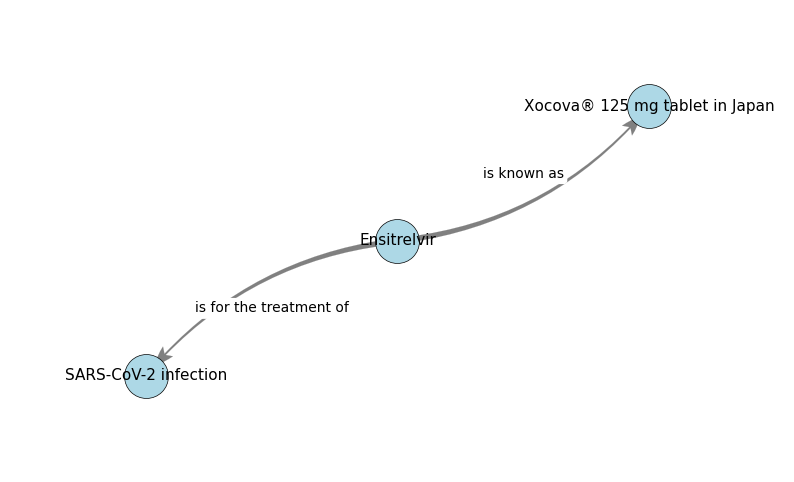

In [ ]:
create_dirgraph(triples_df_chatgpt, "2023-08-19_nx_chatgpt_multidir.png")

#### 5.2.2 text-davinci-003

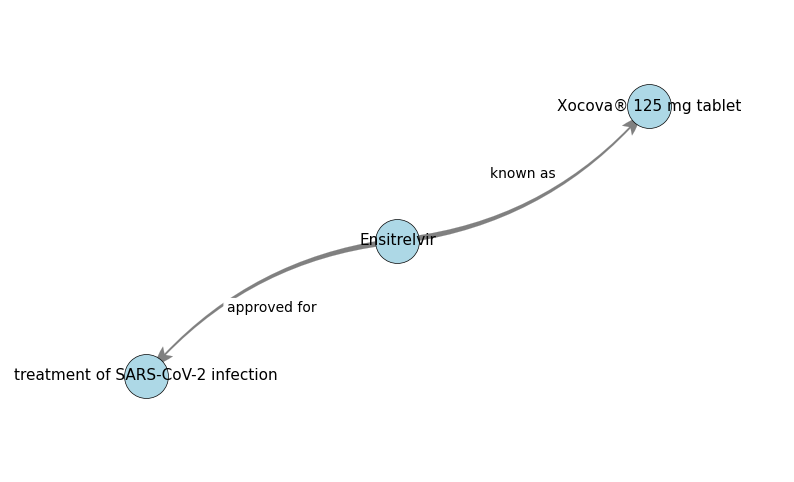

In [ ]:
create_dirgraph(triples_df_davinci, "2023-08-19_nx_davinci_multidir.png")

### 5.3 GraphQAChain

The `GraphQAChain` class creates a chain for question-answering against a graph. Chains are a core component in LangChain and refer to sequences of calls - whether to an LLM, a tool, or a data preprocessing step.

We can enhance the LLM output using the knowledge graph by initialising the `GraphQAChain` and asking the same questions we asked earlier.


#### 5.3.1 gpt-3.5-turbo

In [ ]:
question="Is Ensitrelvir used for treating coronaviral disease?"

In [ ]:
chain = GraphQAChain.from_llm(OpenAI(temperature=0, model_name="gpt-3.5-turbo", openai_api_key=openai.api_key), graph=graph, verbose=True)
chain.run(question)



> Entering new GraphQAChain chain...
Entities Extracted:
Ensitrelvir
Full Context:
Ensitrelvir is known as Xocova® 125 mg tablet in Japan
Ensitrelvir is for the treatment of SARS-CoV-2 infection

> Finished chain.


'Yes, Ensitrelvir is used for treating SARS-CoV-2 infection, which is the virus that causes coronaviral disease.'

In [ ]:
question="Is Ensitrelvir used for treating SARS-CoV-2?"

In [ ]:
chain = GraphQAChain.from_llm(OpenAI(temperature=0, model_name="gpt-3.5-turbo", openai_api_key=openai.api_key), graph=graph, verbose=True)
chain.run(question)



> Entering new GraphQAChain chain...
Entities Extracted:
Ensitrelvir, SARS-CoV-2
Full Context:
Ensitrelvir is known as Xocova® 125 mg tablet in Japan
Ensitrelvir is for the treatment of SARS-CoV-2 infection

> Finished chain.


'Yes, Ensitrelvir is used for treating SARS-CoV-2 infection.'

#### 5.3.2 text-davinci-003

In [ ]:
question="Is Ensitrelvir used for treating SARS-CoV-2?"

In [ ]:
chain = GraphQAChain.from_llm(OpenAI(temperature=0, openai_api_key=openai.api_key), graph=graph, verbose=True)
chain.run(question)



> Entering new GraphQAChain chain...
Entities Extracted:
 Ensitrelvir, SARS-CoV-2
Full Context:
Ensitrelvir known as Xocova® 125 mg tablet
Ensitrelvir approved for treatment of SARS-CoV-2 infection

> Finished chain.


' Yes, Ensitrelvir (known as Xocova® 125 mg tablet) is approved for the treatment of SARS-CoV-2 infection.'

In [ ]:
question="Is Ensitrelvir used for treating COVID-19?"

In [ ]:
chain = GraphQAChain.from_llm(OpenAI(temperature=0, openai_api_key=openai.api_key), graph=graph, verbose=True)
chain.run(question)



> Entering new GraphQAChain chain...
Entities Extracted:
 Ensitrelvir, COVID-19
Full Context:
Ensitrelvir known as Xocova® 125 mg tablet
Ensitrelvir approved for treatment of SARS-CoV-2 infection

> Finished chain.


' Yes, Ensitrelvir (known as Xocova® 125 mg tablet) is approved for treating SARS-CoV-2 infection, which is the virus that causes COVID-19.'

We can see that the responses are accurate having been augmented by the knowledge graph.

## 6. Complex Knowledge Graphs



### 6.1 KnowledgeTriple

We will manually create a more complex graph by supplying a list of triplets to the `GraphIndexCreator` object using the `add_triple()` method and passing it the `KnowledgeTriple` class which creates a knowledge triple from a string with parameters (subject: str, predicate: str, object_: str)

#### 6.1.1 gpt-3.5-turbo

The last two triples were extracted previously using gpt-3.5-turbo.

In [ ]:
triples_lang = [
    ('remdesivir', 'treats', 'coronaviral disease'),
    ('remdesivir', 'attacks', 'coronaviral disease'),
    ('coronaviral disease', 'treated by', 'remdesivir'),
    ('remdesivir', 'treats', 'Ebola'),
    ('remdesivir', 'attacks', 'Ebola'),
    ('remdesivir', 'attacks', 'RdRp of SARS-CoV-2'),
    ('remdesivir', 'attacks', 'NSP12 of SARS-CoV-2'),
    ('Lopinavir/ritonavir', 'treats', 'HIV-1 protease'),
    ('Lopinavir/ritonavir', 'evidences potential for', 'main protease of SARS-CoV-2'),
    ('Silmitasertib', 'inhibits', 'casein kinase 2 pathway in Sonic hedgehog SHH in SARS-CoV-2'),
    ('dipyridamole 100 mg', 'inhibits', 'phosphodiesterase'),
    ('dipyridamole 100 mg', 'works against', 'main protease of SARS-CoV-2'),
    ('dipyridamole 100 mg', 'stops replication of', 'SARS-CoV-2'),
    ('Infliximab', 'attacks', 'tumor necrosis factor in SARS-CoV-2'),
    ('Infliximab', 'attacks', "Infliximab's original target in Rheumatoid arthritis"),
    ('Infliximab', 'attacks', "Infliximab's original target in Crohns disease"),
    ('Infliximab', 'attacks', "Infliximab's original target in ankylosing spondylitis"),
    ('Ensitrelvir', 'is known as', 'Xocova® 125 mg tablet in Japan'),
    ('Ensitrelvir', 'is for the treatment of', 'SARS-CoV-2 infection')
]

In [ ]:
graph = index_creator.from_text('')
for (source, relation, target) in triples_lang:
    graph.add_triple(KnowledgeTriple(source, relation, target))

In [ ]:
graph.get_triples()

[('remdesivir', 'coronaviral disease', 'attacks'),
 ('remdesivir', 'Ebola', 'attacks'),
 ('remdesivir', 'RdRp of SARS-CoV-2', 'attacks'),
 ('remdesivir', 'NSP12 of SARS-CoV-2', 'attacks'),
 ('coronaviral disease', 'remdesivir', 'treated by'),
 ('Lopinavir/ritonavir', 'HIV-1 protease', 'treats'),
 ('Lopinavir/ritonavir',
  'main protease of SARS-CoV-2',
  'evidences potential for'),
 ('Silmitasertib',
  'casein kinase 2 pathway in Sonic hedgehog SHH in SARS-CoV-2',
  'inhibits'),
 ('dipyridamole 100 mg', 'phosphodiesterase', 'inhibits'),
 ('dipyridamole 100 mg', 'main protease of SARS-CoV-2', 'works against'),
 ('dipyridamole 100 mg', 'SARS-CoV-2', 'stops replication of'),
 ('Infliximab', 'tumor necrosis factor in SARS-CoV-2', 'attacks'),
 ('Infliximab',
  "Infliximab's original target in Rheumatoid arthritis",
  'attacks'),
 ('Infliximab', "Infliximab's original target in Crohns disease", 'attacks'),
 ('Infliximab',
  "Infliximab's original target in ankylosing spondylitis",
  'attacks

In [ ]:
triples_new_df_chatgpt = pd.DataFrame(graph.get_triples(), columns=['source', 'target', 'relation'])
triples_new_df_chatgpt

,source,target,relation
0,remdesivir,coronaviral disease,attacks
1,remdesivir,Ebola,attacks
2,remdesivir,RdRp of SARS-CoV-2,attacks
3,remdesivir,NSP12 of SARS-CoV-2,attacks
4,coronaviral disease,remdesivir,treated by
5,Lopinavir/ritonavir,HIV-1 protease,treats
6,Lopinavir/ritonavir,main protease of SARS-CoV-2,evidences potential for
7,Silmitasertib,casein kinase 2 pathway in Sonic hedgehog SHH ...,inhibits
8,dipyridamole 100 mg,phosphodiesterase,inhibits
9,dipyridamole 100 mg,main protease of SARS-CoV-2,works against


#### 6.1.2 text-davinci-003
The last two triples were extracted previously using text-davinci-003.

In [ ]:
triples_lang = [
    ('remdesivir', 'treats', 'coronaviral disease'),
    ('remdesivir', 'attacks', 'coronaviral disease'),
    ('coronaviral disease', 'treated by', 'remdesivir'),
    ('remdesivir', 'treats', 'Ebola'),
    ('remdesivir', 'attacks', 'Ebola'),
    ('remdesivir', 'attacks', 'RdRp of SARS-CoV-2'),
    ('remdesivir', 'attacks', 'NSP12 of SARS-CoV-2'),
    ('Lopinavir/ritonavir', 'treats', 'HIV-1 protease'),
    ('Lopinavir/ritonavir', 'evidences potential for', 'main protease of SARS-CoV-2'),
    ('Silmitasertib', 'inhibits', 'casein kinase 2 pathway in Sonic hedgehog SHH in SARS-CoV-2'),
    ('dipyridamole 100 mg', 'inhibits', 'phosphodiesterase'),
    ('dipyridamole 100 mg', 'works against', 'main protease of SARS-CoV-2'),
    ('dipyridamole 100 mg', 'stops replication of', 'SARS-CoV-2'),
    ('Infliximab', 'attacks', 'tumor necrosis factor in SARS-CoV-2'),
    ('Infliximab', 'attacks', "Infliximab's original target in Rheumatoid arthritis"),
    ('Infliximab', 'attacks', "Infliximab's original target in Crohns disease"),
    ('Infliximab', 'attacks', "Infliximab's original target in ankylosing spondylitis"),
    ('Ensitrelvir', 'known as', 'Xocova® 125 mg tablet'),
    ('Ensitrelvir', 'approved for', 'treatment of SARS-CoV-2 infection')
]

In [ ]:
graph = index_creator.from_text('')
for (source, relation, target) in triples_lang:
    graph.add_triple(KnowledgeTriple(source, relation, target))

In [ ]:
graph.get_triples()

[('remdesivir', 'coronaviral disease', 'attacks'),
 ('remdesivir', 'Ebola', 'attacks'),
 ('remdesivir', 'RdRp of SARS-CoV-2', 'attacks'),
 ('remdesivir', 'NSP12 of SARS-CoV-2', 'attacks'),
 ('coronaviral disease', 'remdesivir', 'treated by'),
 ('Lopinavir/ritonavir', 'HIV-1 protease', 'treats'),
 ('Lopinavir/ritonavir',
  'main protease of SARS-CoV-2',
  'evidences potential for'),
 ('Silmitasertib',
  'casein kinase 2 pathway in Sonic hedgehog SHH in SARS-CoV-2',
  'inhibits'),
 ('dipyridamole 100 mg', 'phosphodiesterase', 'inhibits'),
 ('dipyridamole 100 mg', 'main protease of SARS-CoV-2', 'works against'),
 ('dipyridamole 100 mg', 'SARS-CoV-2', 'stops replication of'),
 ('Infliximab', 'tumor necrosis factor in SARS-CoV-2', 'attacks'),
 ('Infliximab',
  "Infliximab's original target in Rheumatoid arthritis",
  'attacks'),
 ('Infliximab', "Infliximab's original target in Crohns disease", 'attacks'),
 ('Infliximab',
  "Infliximab's original target in ankylosing spondylitis",
  'attacks

In [ ]:
triples_new_df_davinci = pd.DataFrame(graph.get_triples(), columns=['source', 'target', 'relation'])
triples_new_df_davinci

,source,target,relation
0,remdesivir,coronaviral disease,attacks
1,remdesivir,Ebola,attacks
2,remdesivir,RdRp of SARS-CoV-2,attacks
3,remdesivir,NSP12 of SARS-CoV-2,attacks
4,coronaviral disease,remdesivir,treated by
5,Lopinavir/ritonavir,HIV-1 protease,treats
6,Lopinavir/ritonavir,main protease of SARS-CoV-2,evidences potential for
7,Silmitasertib,casein kinase 2 pathway in Sonic hedgehog SHH ...,inhibits
8,dipyridamole 100 mg,phosphodiesterase,inhibits
9,dipyridamole 100 mg,main protease of SARS-CoV-2,works against


### 6.2 Plot Knowledge Graph

In [ ]:
def create_dirgraph(df, filename):
    # Create a directed multigraph to store all relations
    graph = nx.MultiDiGraph()

    # Add edges of all relations to the graph
    for relation in df['relation'].unique():
        edges = df[df['relation'] == relation][["source", "target"]].to_numpy()
        graph.add_edges_from(edges, relation=relation)

    # Set the layout of the graph
    pos = nx.spring_layout(graph, seed=42, k=3.0)  # Adjust k to spread out nodes more

    # Customise the appearance of the graph
    node_options = {
        'node_color': 'lightblue',
        'node_size': 1000,
        'edgecolors': 'black',
        'linewidths': 0.5
    }
    edge_options = {
        'arrows': True,
        'arrowstyle': 'fancy,head_width=1,head_length=1.5',
        'width': 0.1,
        'edge_color': 'gray'
    }

    # Draw the graph
    plt.figure(figsize=(25, 25))
    plt.margins(x=0.2)

    # Draw nodes
    nx.draw_networkx_nodes(graph, pos, **node_options)

    # Draw edges with arrowheads
    nx.draw_networkx_edges(graph, pos, **edge_options)

    # Draw edge labels for each relation (in both directions)
    for source, target, key, attr in graph.edges(keys=True, data=True):
        x = (pos[source][0] + pos[target][0]) / 2.0
        y = (pos[source][1] + pos[target][1]) / 2.0
        offset = 0.05 * key
        pos_offset = (x, y + offset)

        # Display the relation label for this edge
        label_text = attr['relation']
        if graph.has_edge(target, source, key=key):
            label_text_rev = graph.get_edge_data(target, source, key)['relation']
            if label_text != label_text_rev:
                label_text = f"{label_text}\n{label_text_rev}"  # Separate labels if they are different

        plt.text(*pos_offset, label_text,
                 color='black', ha='center', va='center', fontsize=10,
                 bbox=dict(boxstyle='round,pad=0.2', ec='white', fc='white'))  # Adjust bbox to avoid overlap

    # Draw labels
    nx.draw_networkx_labels(graph, pos, font_color='black', font_size=11)

    plt.axis('off')
    plt.savefig(filename)
    plt.show()

#### 6.2.1 gpt-3.5-turbo

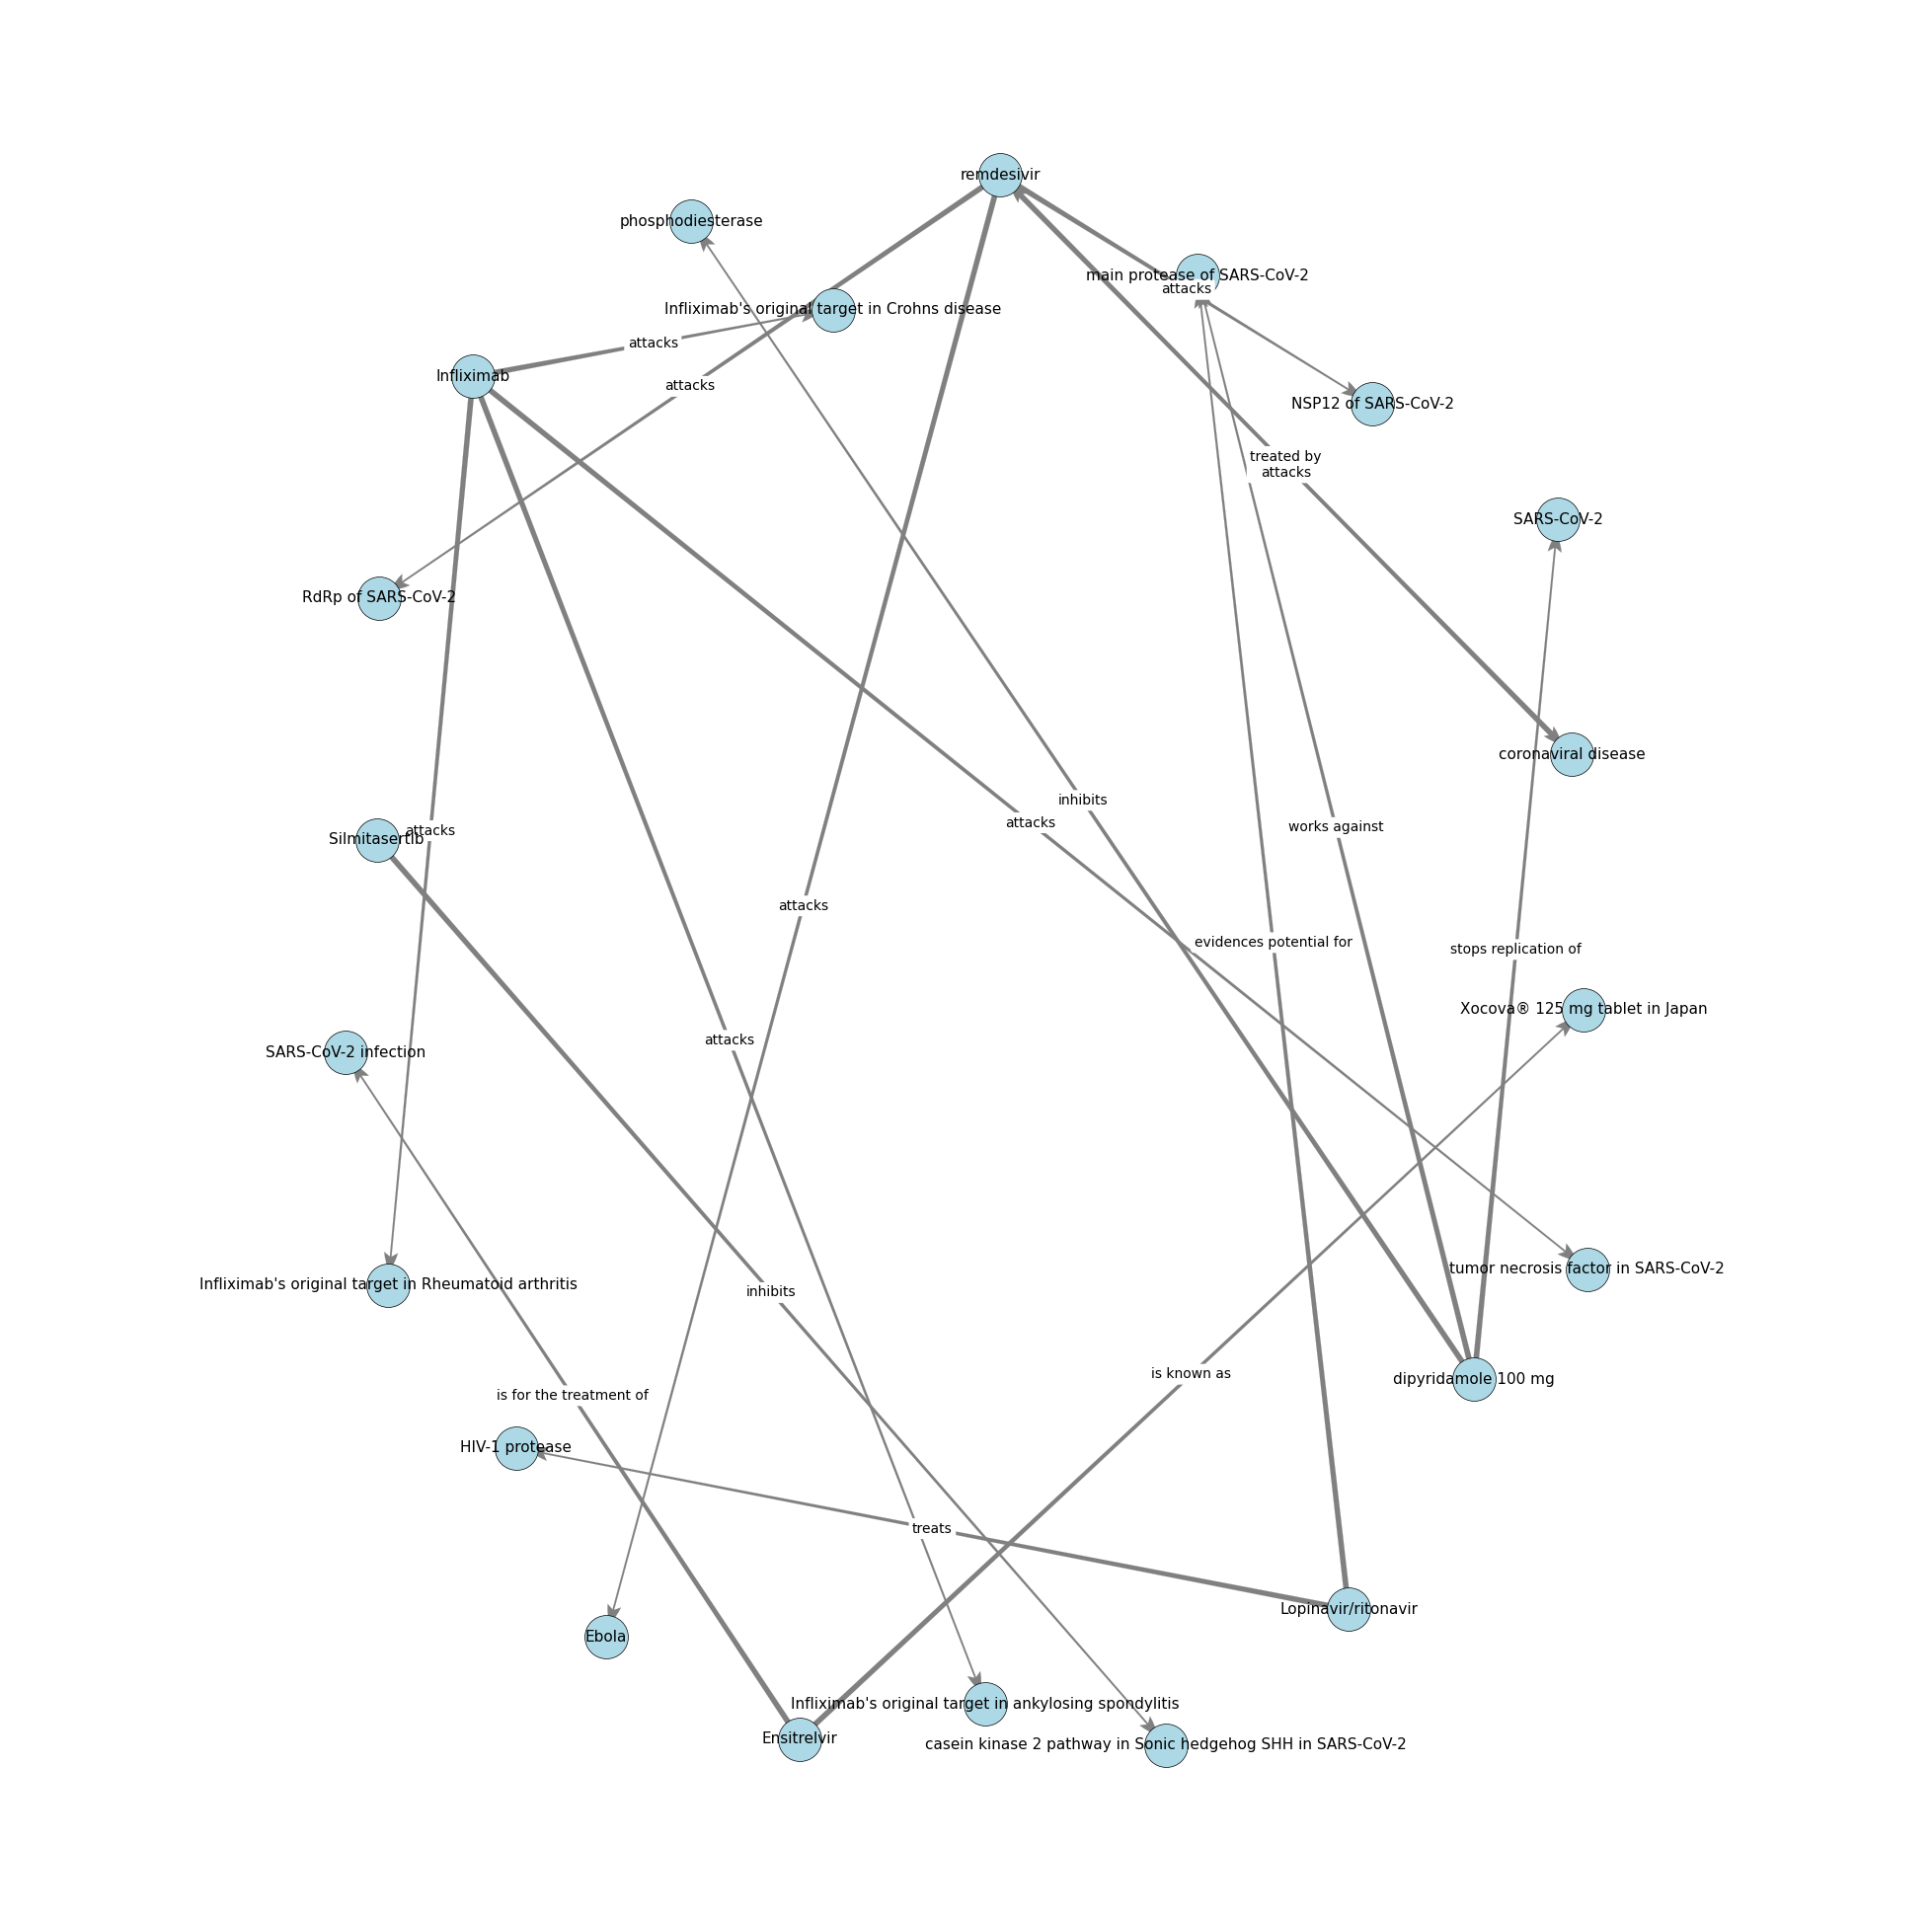

In [ ]:
create_dirgraph(triples_new_df_chatgpt, "2023-08-19_nx_chatgpt_multidir_lg.png")

#### 6.2.2 text-davinci-003

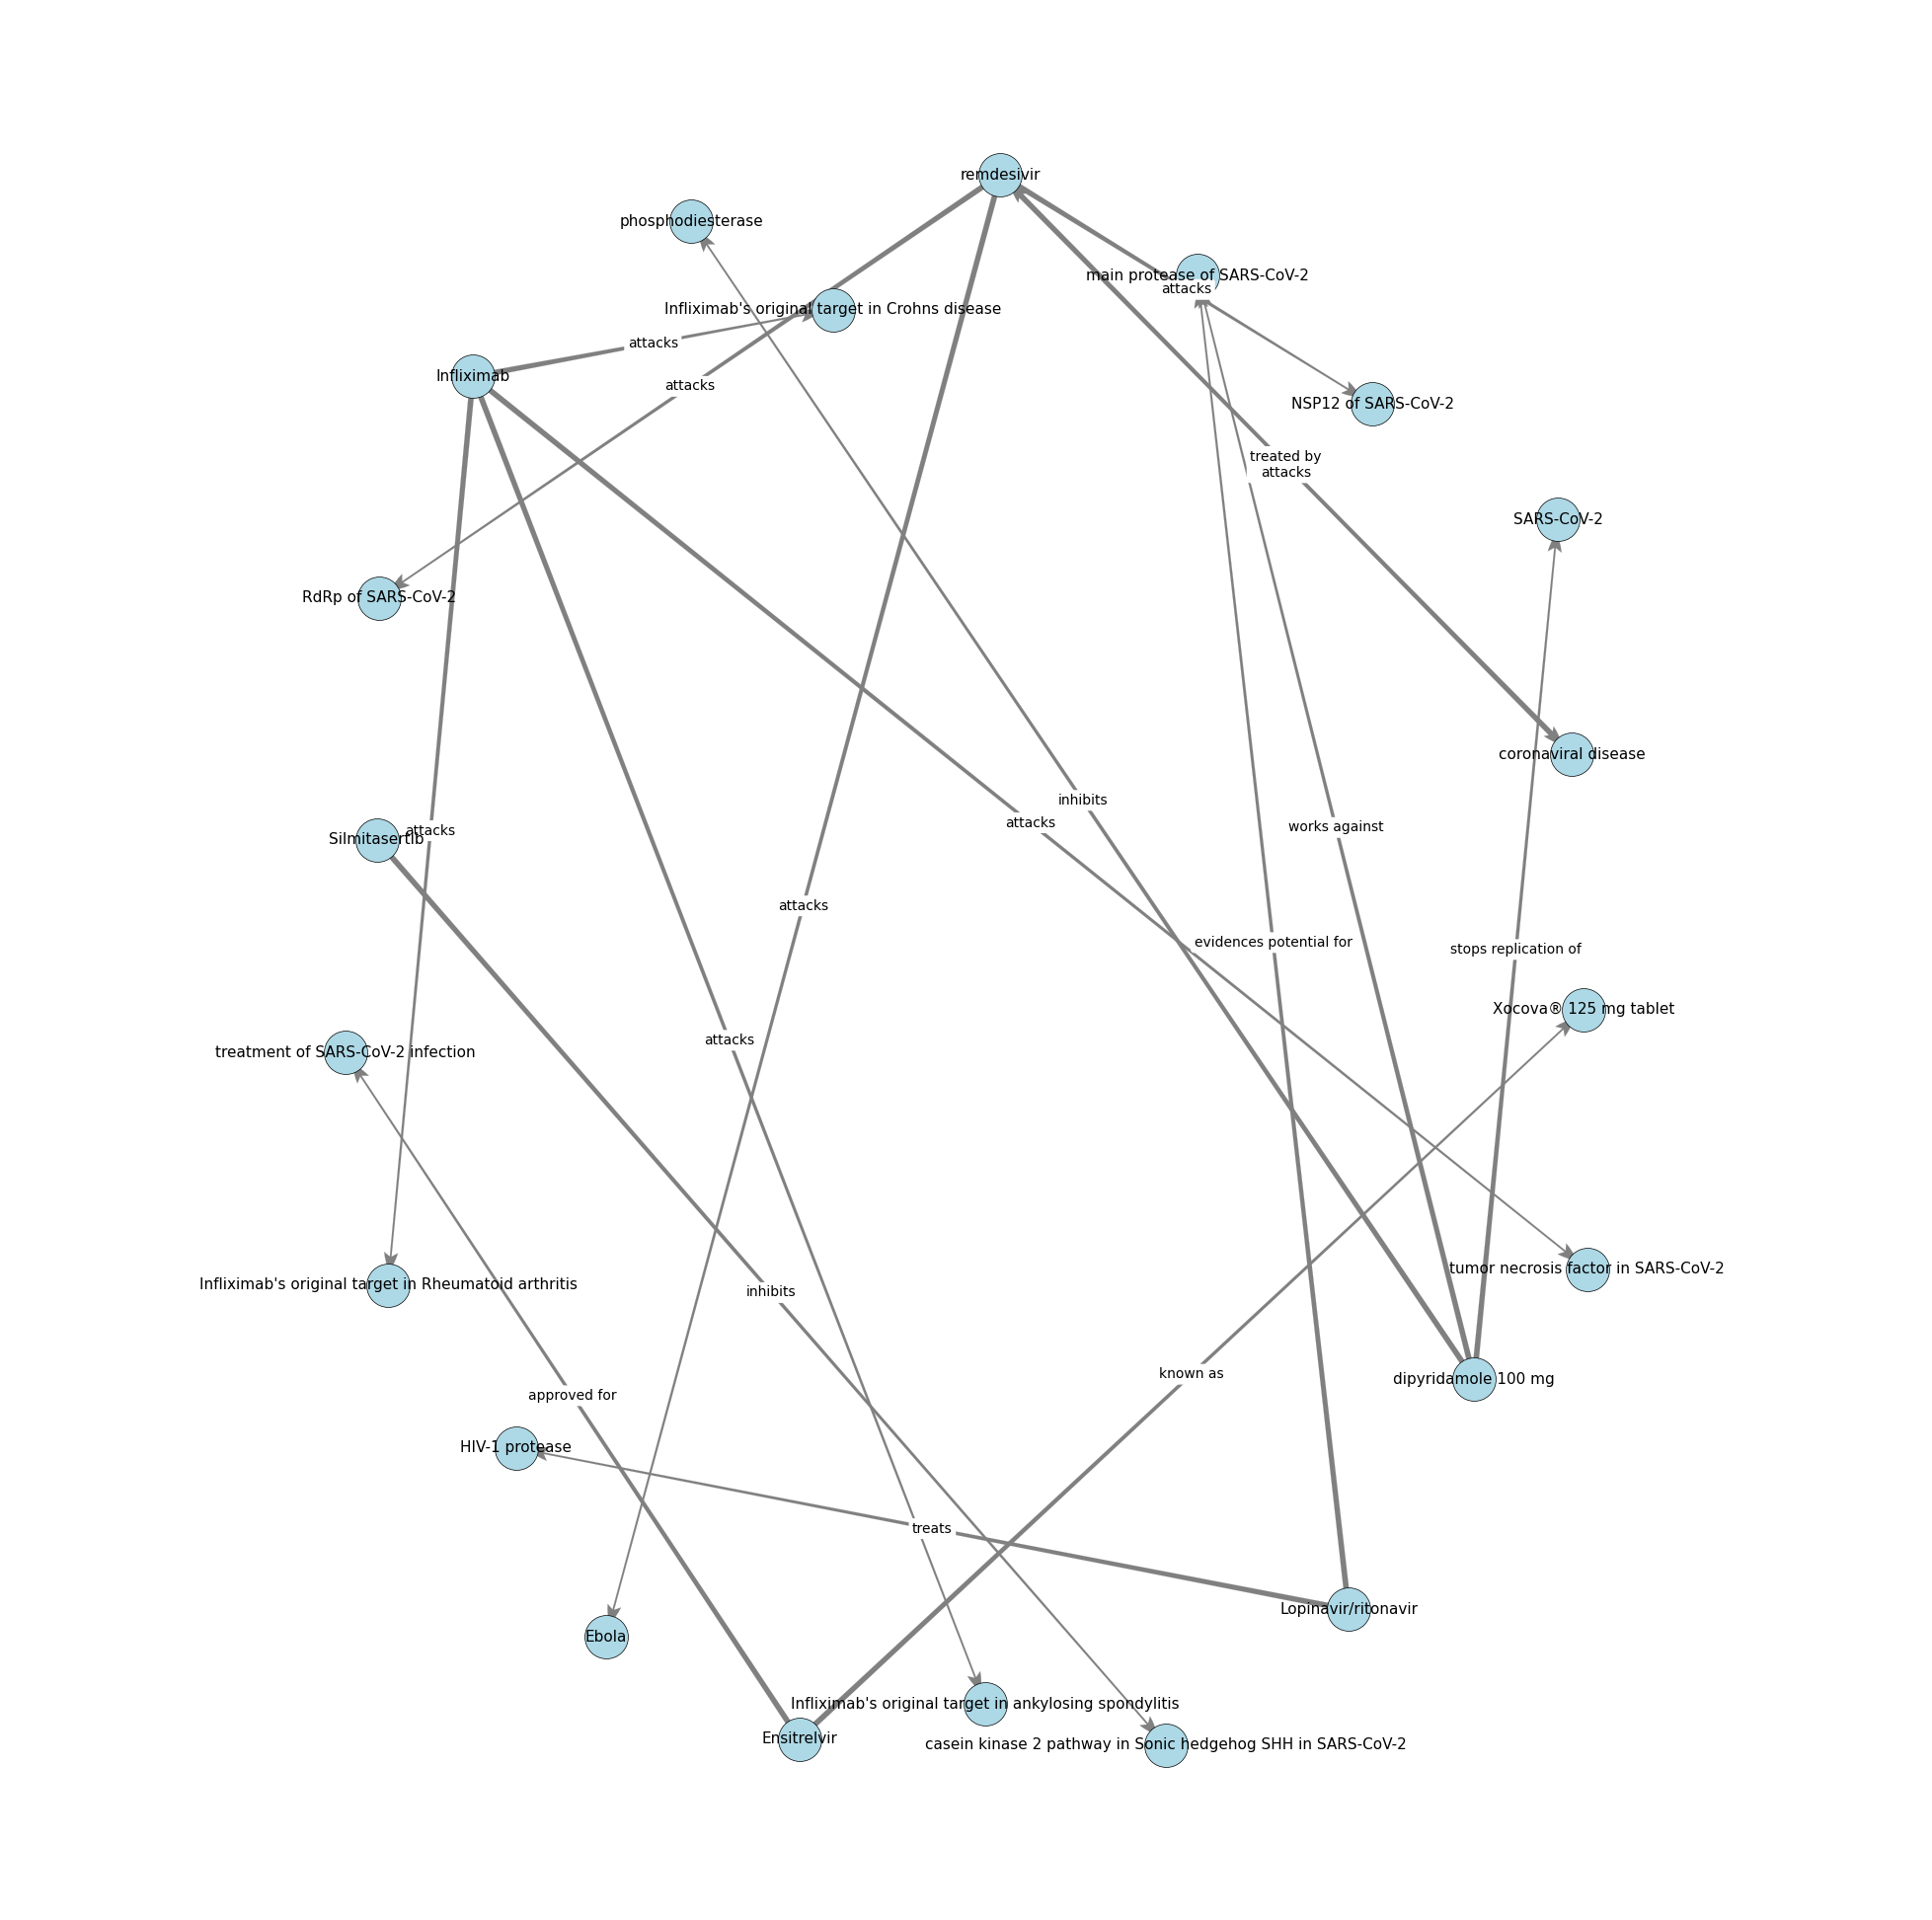

In [ ]:
create_dirgraph(triples_new_df_davinci, "2023-08-19_nx_davinci_multidir_lg.png")

### 6.3 GraphQAChain

With the larger graph we can enhance the LLM output by initialising the `GraphQAChain` and asking the same questions we asked earlier.

#### 6.3.1 gpt-3.5-turbo

In [ ]:
question="Is Ensitrelvir used for treating SARS-CoV-2?"

In [ ]:
chain = GraphQAChain.from_llm(OpenAI(temperature=0, model_name="gpt-3.5-turbo", openai_api_key=openai.api_key), graph=graph, verbose=True)
chain.run(question)



> Entering new GraphQAChain chain...
Entities Extracted:
Ensitrelvir, SARS-CoV-2
Full Context:
Ensitrelvir is known as Xocova® 125 mg tablet in Japan
Ensitrelvir is for the treatment of SARS-CoV-2 infection

> Finished chain.


'Yes, Ensitrelvir is used for treating SARS-CoV-2 infection.'

In [ ]:
question="Can SARS-CoV-2 be treated by Ensitrelvir?"

In [ ]:
chain = GraphQAChain.from_llm(OpenAI(temperature=0, model_name="gpt-3.5-turbo", openai_api_key=openai.api_key), graph=graph, verbose=True)
chain.run(question)



> Entering new GraphQAChain chain...
Entities Extracted:
SARS-CoV-2, Ensitrelvir
Full Context:
Ensitrelvir is known as Xocova® 125 mg tablet in Japan
Ensitrelvir is for the treatment of SARS-CoV-2 infection

> Finished chain.


'Yes, SARS-CoV-2 can be treated by Ensitrelvir.'

In [ ]:
question="Can coronaviral disease be treated by Ensitrelvir?"

In [ ]:
chain = GraphQAChain.from_llm(OpenAI(temperature=0, model_name="gpt-3.5-turbo", openai_api_key=openai.api_key), graph=graph, verbose=True)
chain.run(question)



> Entering new GraphQAChain chain...
Entities Extracted:
coronaviral disease, Ensitrelvir
Full Context:
coronaviral disease treated by remdesivir
Ensitrelvir is known as Xocova® 125 mg tablet in Japan
Ensitrelvir is for the treatment of SARS-CoV-2 infection

> Finished chain.


'Yes, coronaviral disease can be treated by Ensitrelvir.'

#### 6.3.2 text-davinci-003

In [ ]:
question="Is Ensitrelvir used for treating SARS-CoV-2?"

In [ ]:
chain = GraphQAChain.from_llm(OpenAI(temperature=0, openai_api_key=openai.api_key), graph=graph, verbose=True)
chain.run(question)



> Entering new GraphQAChain chain...
Entities Extracted:
 Ensitrelvir, SARS-CoV-2
Full Context:
Ensitrelvir known as Xocova® 125 mg tablet
Ensitrelvir approved for treatment of SARS-CoV-2 infection

> Finished chain.


' Yes, Ensitrelvir (known as Xocova® 125 mg tablet) is approved for the treatment of SARS-CoV-2 infection.'

In [ ]:
question="Is Ensitrelvir used for treating COVID-19?"

In [ ]:
chain = GraphQAChain.from_llm(OpenAI(temperature=0, openai_api_key=openai.api_key), graph=graph, verbose=True)
chain.run(question)



> Entering new GraphQAChain chain...
Entities Extracted:
 Ensitrelvir, COVID-19
Full Context:
Ensitrelvir known as Xocova® 125 mg tablet
Ensitrelvir approved for treatment of SARS-CoV-2 infection

> Finished chain.


' Yes, Ensitrelvir (known as Xocova® 125 mg tablet) is approved for treating SARS-CoV-2 infection, which is the virus that causes COVID-19.'

We only had two triples relating to Ensitrelvir in the knowledge graph but querying on other triples would have extracted the correct information from the more expansive knowledge graph demonstrating that the model can not only scale to larger graphs but can also efficiently navigate a more extensive knowledge base.

### References

* https://mlabonne.github.io/blog/posts/Article_Improve_ChatGPT_with_Knowledge_Graphs.html

* https://medium.com/@pankaj_pandey/enhancing-chatgpt-with-knowledge-graphs-a-deep-dive-8f9d9523f01

* S. Pan, L. Luo, Y. Wang, C. Chen, J. Wang and X. Wu, "Unifying Large Language Models and Knowledge Graphs: A Roadmap," in *IEEE Transactions on Knowledge and Data Engineering*, vol. 36, no. 7, pp. 3580-3599, July 2024, [doi:10.1109/TKDE.2024.3352100](https://doi.org/10.1109/TKDE.2024.3352100)

* https://sunila-gollapudi.medium.com/using-knowledge-graphs-to-enhance-retrieval-augmented-generation-rag-systems-14197efc1bab

* https://medium.com/neo4j/enhancing-the-accuracy-of-rag-applications-with-knowledge-graphs-ad5e2ffab663

* https://graphaware.com/blog/episode-2-gpt-prompt-engineering/

* https://medium.com/@tredencestudio/building-better-knowledge-graphs-llamaindex-versus-langchain-9661eefb1bb4